# GMRQ

We use cross-validation and the generalized matrix Rayleigh quotient (GMRQ) for selecting MSM hyperparameters. The GMRQ is a criterion which "scores" how well the MSM eigenvectors generated on the training dataset serve as slow coordinates for the test dataset [1].

[1] McGibbon, R. T. and V. S. Pande, Variational cross-validation of slow dynamical modes in molecular kinetics (2014)


This docuentation borrows/copies heavily from the msmbuilder.org website



In [4]:
# GMRQ hyperparameter selection

import numpy as np


import os,sys
import pandas as pd
import numpy as np
import pickle
from msmbuilder.cluster import KMeans
from sklearn.cross_validation import KFold
from msmbuilder.msm import MarkovStateModel


# First, let's read in the tICA coords for just ntica=4 (tica lagtime=1):

tags = ['a','b','c','d','e','f','g','h']
tags += ['i','j','k','l','m','n','o','p']
tags += ['q','r','s','t','u','v','w','x']
tags += ['aa','bb','cc','dd','ee','ff','gg','hh']

ntica_max = 20
tica_lag_times = np.array([1, 2, 4, 10, 40, 100])

for tica_lag in tica_lag_times:
    
    tica_coords = [np.load('/Volumes/vv-data2017/ising_long_30C/tica/%s_all.tica%d.lag%d.npy'%(tag,ntica_max,tica_lag)) for tag in tags]

    cv = KFold(len(tica_coords),n_folds=5)
    results = []

    n_clusters = [200] #[50,100,200, 500]
    n_tica = [2,20]  # 2, 10] # 4, 6, 8, 10]

    #lag_times = np.array([1, 2, 4, 10, 15, 20, 30, 50, 75, 100, 200])
    msm_lagtimes = [100] # np.array([1, 10, 40, 100, 400])
    
    for msm_lagtime in msm_lagtimes:
        for n in n_clusters:
            for ntica in n_tica:
                
                ########################################################
                ### 1) start with an initial guess of the cluster centers

                # First determine the mins and maxs of each tica_coordinate across the trajectories
                tica_mins = np.zeros( (len(tica_coords),ntica) )
                tica_maxs = np.zeros( (len(tica_coords),ntica) ) 
                for i in range(len(tica_coords)):
                    tica_mins[i,:] = np.min(tica_coords[i][:,0:ntica], axis=0)
                    tica_maxs[i,:] = np.max(tica_coords[i][:,0:ntica], axis=0)
                # ... and then pick the biggest ranges
                best_tica_mins = np.min(tica_mins, axis=0)
                best_tica_maxs = np.min(tica_maxs, axis=0)
                print 'best_tica_mins', best_tica_mins
                print 'best_tica_maxs', best_tica_maxs

                # pick random points in the ranges
                initial_generators = np.random.random( (n,ntica) )
                widths = best_tica_maxs - best_tica_mins
                for i in range(ntica):
                    initial_generators[:,i] = initial_generators[:,i]*widths[i] + best_tica_mins[i]
                # print 'initial_generators', initial_generators


                kmeans = KMeans(n_clusters=n, init=initial_generators)

                print "Clustering data to %d clusters..."%n
                for fold,(train_index,test_index) in enumerate(cv):

                    print 'fold,(train_index,test_index)', fold,(train_index,test_index)

                    # create a subset of the data to do initial cluster on
                    tica_coords_subset = [tica_coords[t][0::100,0:ntica] for t in train_index]
                    kmeans.fit(tica_coords_subset)

                    training_data = [tica_coords[t][:,0:ntica] for t in train_index]
                    testing_data = [tica_coords[t][:,0:ntica] for t in test_index]
                    assignments_train = kmeans.predict(training_data)
                    assignments_test = kmeans.predict(testing_data)
                    msm = MarkovStateModel(lag_time=msm_lagtime)
                    msm.fit(assignments_train)
                    train_score = msm.score(assignments_train)
                    test_score = msm.score(assignments_test)

                    results.append({'train_score':train_score,
                                    'test_score':test_score,
                                    'n_states':n,
                                    'n_tica':ntica,
                                    'tica_lag':tica_lag,
                                    'msm_lag':msm_lagtime,
                                    'fold':fold})

        results = pd.DataFrame(results)
        print results

        outfile = '/Volumes/vv-data2017/ising_long_30C/gmrq/gmrq.ticalag%d.msmlag%d.pkl'%(tica_lag,msm_lagtime)
        with open(outfile,'wb') as result_fn:
            pickle.dump(results,result_fn)


best_tica_mins [-1.21593284 -8.87238539]
best_tica_maxs [ 1.20336801  7.56398754]
Clustering data to 200 clusters...
fold,(train_index,test_index) 0 (array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31]), array([0, 1, 2, 3, 4, 5, 6]))
MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
fold,(train_index,test_index) 1 (array([ 0,  1,  2,  3,  4,  5,  6, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31]), array([ 7,  8,  9, 10, 11, 12, 13]))
MSM contains 1 strongly connected component above weight=0.01. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.01. Com

/Users/vv/anaconda/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:821: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  n_jobs=self.n_jobs)


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1])

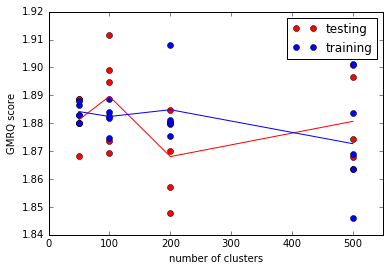

In [41]:
# A plot of GMRQ versus number of states


%matplotlib inline
import matplotlib.pyplot as plt

n_folds=5
mean_test_score = [results['test_score'][n_folds*i:n_folds*(i+1)].mean() for i in range(len(n_clusters))]
mean_train_score = [results['train_score'][n_folds*i:n_folds*(i+1)].mean() for i in range(len(n_clusters))]

plt.plot(results['n_states'],results['test_score'],'ro')
plt.plot(results['n_states'],results['train_score'],'bo')
plt.plot(n_clusters,mean_test_score,'r-')
plt.plot(n_clusters,mean_train_score,'b-')
plt.xlim(0,550)
plt.legend(['testing','training'])
plt.xlabel('number of clusters')
plt.ylabel('GMRQ score')



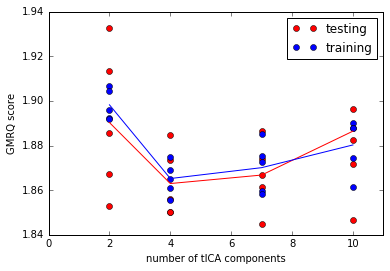

In [49]:
# A plot of GMRQ versus number of tica components

%matplotlib inline
import matplotlib.pyplot as plt

n_folds=5
mean_test_score = [results['test_score'][n_folds*i:n_folds*(i+1)].mean() for i in range(len(n_tica))]
mean_train_score = [results['train_score'][n_folds*i:n_folds*(i+1)].mean() for i in range(len(n_tica))]

plt.plot(results['n_tica'],results['test_score'],'ro')
plt.plot(results['n_tica'],results['train_score'],'bo')
plt.plot(n_tica,mean_test_score,'r-')
plt.plot(n_tica,mean_train_score,'b-')
plt.xlim(0,11)
plt.legend(['testing','training'])
plt.xlabel('number of tICA components')
plt.ylabel('GMRQ score')

